# 執行腳本

In [1]:
# ==========================================
# 0. 環境設定與參數配置 (Configuration)
# ==========================================
%load_ext autoreload
%autoreload 2

# 1. 標準函式庫
import os
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# 2. 專案模組
import data_loader
import data_preprocessing
import feature_eng
import model_train
from experiment_logger import ExperimentLogger

# ------------------------------------------
# 🔧 [參數設定區] 每次實驗只要改這裡！
# ------------------------------------------
# 實驗筆記 (這會寫入 Log，很重要！)
EXPERIMENT_NOTE = "過擬合設定"

# 模型名稱 (用於 Log 識別)
MODEL_NAME = "XGBoost_Optuna_Regularized"

# 檔案路徑設定
PATH_SUBMISSION_SAMPLE = 'data/sample_submission.csv'
PATH_LOG_FILE = 'experiments/training_log.csv'
PATH_MODEL_DIR = 'experiments/models'

print(f"🚀 準備開始實驗: {EXPERIMENT_NOTE}")

🚀 準備開始實驗: 過擬合設定


In [2]:
# ==========================================
# 1. 數據處理流水線 (Data Pipeline)
# ==========================================

# Step 1: 載入 (Load)
print("📥 正在載入資料...")
df_raw = data_loader.load_and_merge_data()

# Step 2: 清洗 (Preprocess)
print("🧹 正在清洗資料...")
df_clean = data_preprocessing.clean_data(df_raw)

# Step 3: 特徵工程 (Feature Engineering)
print("⚙️ 正在計算特徵...")
df_features = feature_eng.add_technical_indicators(df_clean)

print("✅ 資料準備完成！")

📥 正在載入資料...
🚀 [Loader] 開始讀取資料...
✅ 資料載入完成 (尚未清洗)！大小：(852, 12)
🧹 正在清洗資料...
🧹 [Preprocessing] 開始清洗資料...
✅ 資料清洗完成！沒有 NaN 了。
⚙️ 正在計算特徵...
📊 [Feature Engineering] 轉為純時間特徵模式 (11 支股票)...
✅ 特徵工程 (時間版) 完成！欄位數: 26
✅ 資料準備完成！


In [3]:
# ==========================================
# 2. 訓練前檢查站 (Pre-training Check)
# ==========================================
print("🧐 正在進行最終資料檢查...")

# 1. 檢查空值 (Critical)
nan_count = df_features.isnull().sum().sum()
if nan_count > 0:
    print(f"❌ 警告！偵測到 {nan_count} 個空值！訓練可能會報錯。")
    # 顯示有空值的欄位
    print(df_features.columns[df_features.isnull().any()].tolist())
else:
    print("✅ 通過：無空值 (NaN Free)")

# 2. 檢查資料形狀
print(f"📊 特徵矩陣規模: {df_features.shape[0]} 列 x {df_features.shape[1]} 欄")

# 3. 快速預覽
display(df_features.tail(3)) # 用 display 在 notebook 比較好看

🧐 正在進行最終資料檢查...
✅ 通過：無空值 (NaN Free)
📊 特徵矩陣規模: 852 列 x 26 欄


,date,0056_close_y,1101_close,2327_close,2352_close,2385_close,2449_close,2915_close,3005_close,3532_close,...,Sin_Week,Cos_Week,Sin_Month,Cos_Month,2352_close_Return,2352_close_Bias,9945_close_Return,9945_close_Bias,1101_close_Return,1101_close_Bias
849,8084,375.4361,38.80,292.0,14.90,72.3,30.9,66.6,43.05,132.0,...,-9.510565e-01,0.309017,0.951057,3.090170e-01,0.038328,0.051517,0.062003,0.068800,0.014379,0.051206
850,8085,375.4361,38.60,291.5,14.85,74.6,32.1,67.7,45.55,131.5,...,-1.440549e-12,1.000000,1.000000,3.601371e-13,-0.003356,0.028393,0.010479,0.055347,-0.005155,0.018201
851,8086,375.4361,38.95,280.5,15.10,76.6,31.0,67.8,42.00,127.0,...,9.510565e-01,0.309017,0.951057,-3.090170e-01,0.016835,0.033539,0.031111,0.064220,0.009067,0.016706


[I 2026-01-03 15:21:31,216] A new study created in memory with name: no-name-9d5a827f-7d10-4d18-902d-8fe660780137


🚀 [Training] 啟動模型訓練生產線...
✅ 成功找到考卷檔案: data/sample_submission.csv
📚 歷史資料總數: (695, 24)
📝 預測資料集: (157, 24)
   👉 實際訓練用: (556, 24), 驗證用: (139, 24)
🤖 [Optuna] 啟動自動化參數搜尋...


[I 2026-01-03 15:21:35,694] Trial 0 finished with value: 36.508709251559445 and parameters: {'n_estimators': 2723, 'learning_rate': 0.03377509493068987, 'max_depth': 5, 'reg_alpha': 0.1758266909941547, 'reg_lambda': 0.0018409036324129914, 'min_child_weight': 3, 'subsample': 0.7714647344299908, 'colsample_bytree': 0.638007524118712}. Best is trial 0 with value: 36.508709251559445.
[I 2026-01-03 15:21:39,713] Trial 1 finished with value: 38.72927844865702 and parameters: {'n_estimators': 2616, 'learning_rate': 0.04537228316006795, 'max_depth': 5, 'reg_alpha': 0.2504647242523507, 'reg_lambda': 0.3089221213436379, 'min_child_weight': 1, 'subsample': 0.7519097031326247, 'colsample_bytree': 0.6581230709835919}. Best is trial 0 with value: 36.508709251559445.
[I 2026-01-03 15:21:44,282] Trial 2 finished with value: 44.189999314189166 and parameters: {'n_estimators': 2357, 'learning_rate': 0.0422232833224116, 'max_depth': 6, 'reg_alpha': 0.00241295667868556, 'reg_lambda': 3.9310052323167612, '

🎉 找到最佳參數: {'n_estimators': 2723, 'learning_rate': 0.03377509493068987, 'max_depth': 5, 'reg_alpha': 0.1758266909941547, 'reg_lambda': 0.0018409036324129914, 'min_child_weight': 3, 'subsample': 0.7714647344299908, 'colsample_bytree': 0.638007524118712}
📉 最佳分數 (RMSE): 36.5087
📊 驗證走勢圖已儲存: experiments/plots/val_20260103_1521_rmse_36.51.png
📊 特徵重要性圖已儲存: experiments/plots/fi_20260103_1521.png
📊 相關係數熱力圖已儲存: experiments/plots/heatmap_20260103_1521.png
🚀 使用完整歷史資料重新訓練 (Full Retrain)...
🔮 正在進行最終預測...
🎉 考卷已填寫完成: submission.csv
------------------------------
🏆 本次驗證分數 (RMSE): 36.5087
------------------------------


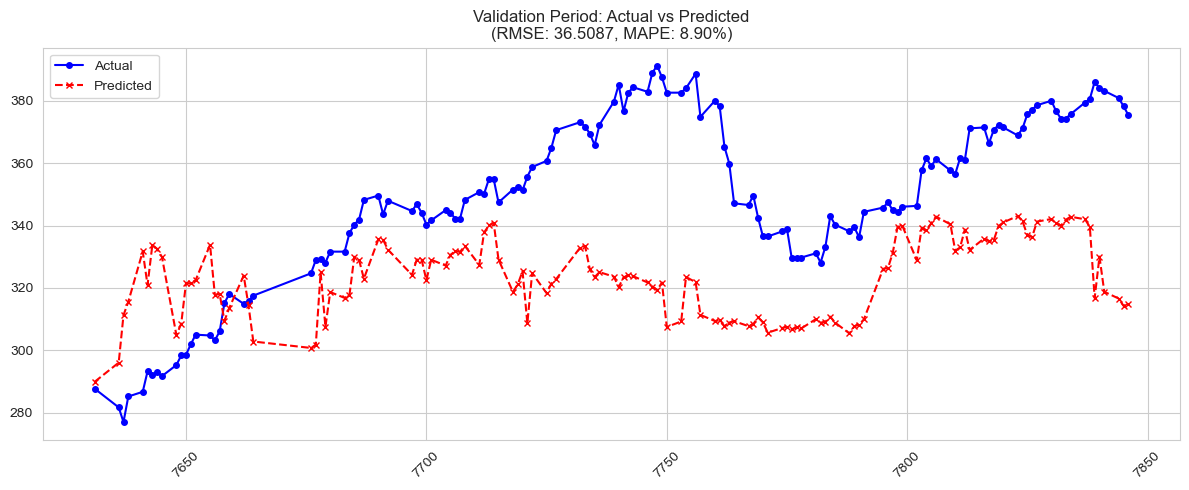

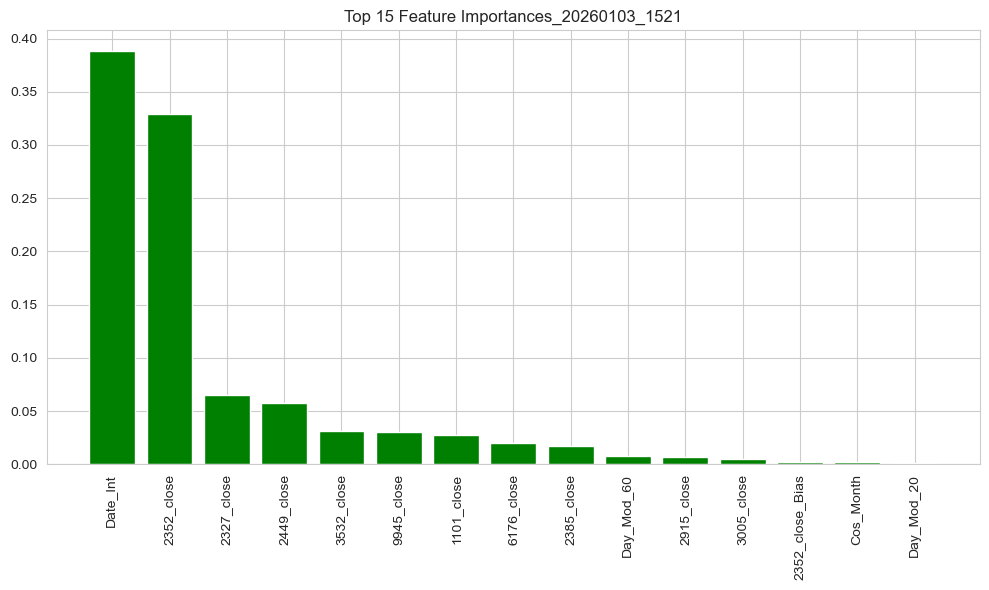

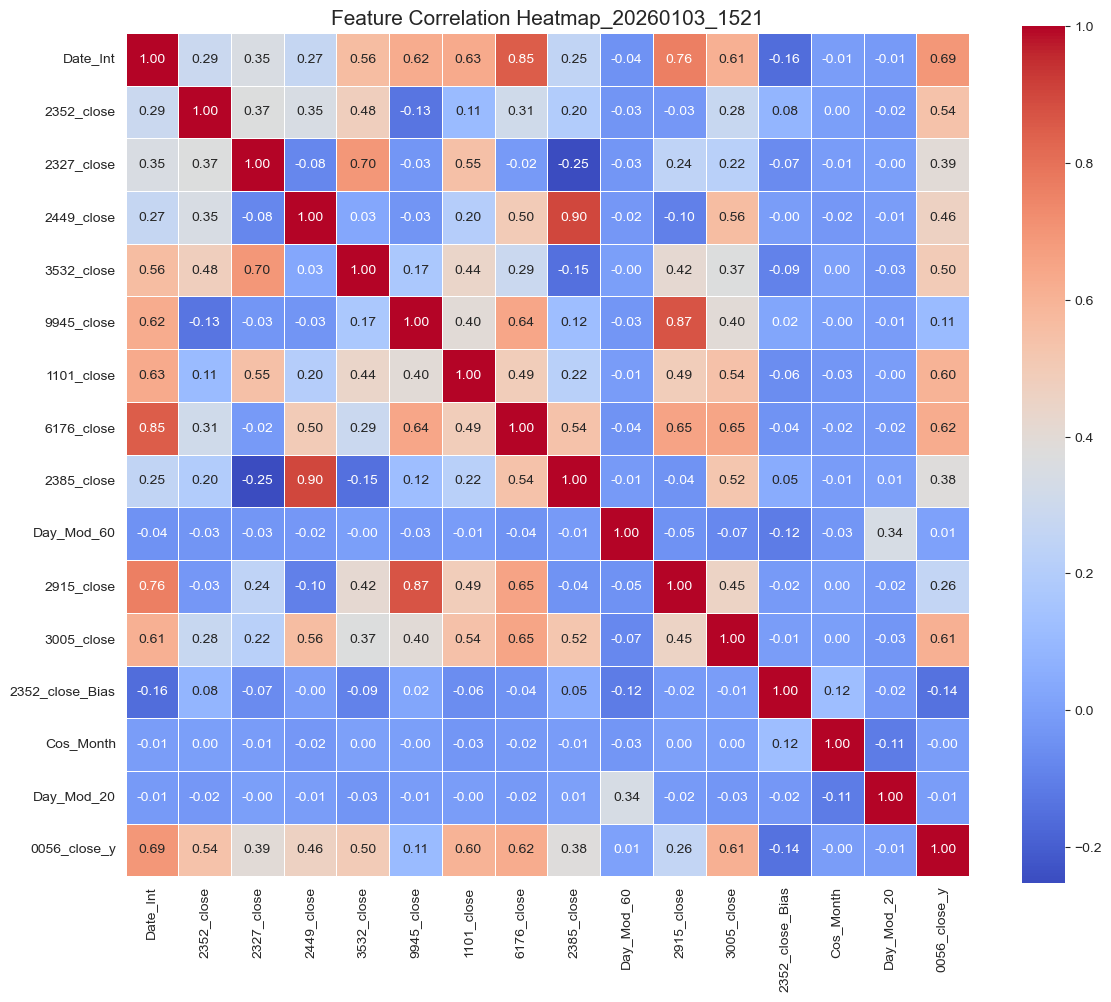

In [4]:
# ==========================================
# 3. 模型訓練與預測 (Training & Prediction)
# ==========================================
import time # 確保開頭有 import

# --- 開始計時 ---
start_time = time.time()
# 執行訓練
# use_optuna=True  -> 開啟自動調參 (會跑比較久，但找參數比較準)
# use_optuna=False -> 用原本的手動參數 (跑比較快)
model, score = model_train.train_and_predict(
    df_features, 
    submission_file=PATH_SUBMISSION_SAMPLE,
    use_optuna=True
)

# --- 結束計時 ---
end_time = time.time()
duration_seconds = end_time - start_time
duration_min = duration_seconds / 60  # 轉成分鐘，方便閱讀
print("-" * 30)
print(f"🏆 本次驗證分數 (RMSE): {score:.4f}")
print("-" * 30)

In [5]:
# ==========================================
# 5. 實驗歸檔 (Logging & Saving)
# ==========================================

# --- A. 寫入實驗紀錄表 (CSV) ---
logger = ExperimentLogger(log_file=PATH_LOG_FILE)
feature_list = df_features.drop(['date', '0056_close_y'], axis=1, errors='ignore').columns.tolist()
final_note = f"{EXPERIMENT_NOTE} | 結果分數: {score:.4f} | 耗時: {duration_min:.2f}min"

logger.log(
    score=score, 
    model_name=MODEL_NAME, 
    features=feature_list,
    note=final_note
)

# --- B. 儲存模型實體 (Pickle) ---
# 確保資料夾存在
os.makedirs(PATH_MODEL_DIR, exist_ok=True)

# 產生檔名：時間_分數.pkl
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
filename = f"{PATH_MODEL_DIR}/model_{timestamp}_rmse_{score:.4f}_{duration_min:.1f}m.pkl"

joblib.dump(model, filename)

print(f"⏱️ 本次執行耗時: {duration_min:.2f} 分鐘")
print(f"💾 模型已備份: {filename}")
print("\n✅ 全流程結束！請去上傳 submission.csv 吧！")

📝 實驗紀錄已儲存至: experiments/training_log.csv
⏱️ 本次執行耗時: 1.58 分鐘
💾 模型已備份: experiments/models/model_20260103_1523_rmse_36.5087_1.6m.pkl

✅ 全流程結束！請去上傳 submission.csv 吧！
